# Install Dependencies and Setup

In [ ]:
!pip install tensorflow
!pip install matplotlib

In [ ]:
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras import regularizers

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Dataset

In [ ]:
def load_dataset(data_dir, img_height=224, img_width=224, batch_size=64, seed=123):
  img_size = (img_height, img_width)

  train_ds = tf.keras.utils.image_dataset_from_directory (
    data_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
  )

  val_ds = tf.keras.utils.image_dataset_from_directory (
    data_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
  )

  return train_ds, val_ds

In [ ]:
import matplotlib.pyplot as plt

def plot_dataset(ds, class_names):
  plt.figure(figsize=(10, 10))
  for images, labels in ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")


def plot_dataset_distribution(dataset, class_names):
    num_images_per_class = [0] * len(class_names)

    for _, labels in dataset:
        for label in labels:
            num_images_per_class[label] += 1

    # Create a bar plot showing the number of images per class
    plt.figure(figsize=(10, 8))
    bars = plt.bar(class_names, num_images_per_class, color='skyblue')

    plt.xlabel('Architects')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images per Class')
    plt.xticks(rotation=45)

    # Display numeric values on top of the bars
    for bar, num_images in zip(bars, num_images_per_class):
        plt.text(bar.get_x() + bar.get_width() / 2, num_images + 5, str(num_images),
                 ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

## Architectural Styles Dataset from Kaggle

In [ ]:
!rm -rf g-images-dataset/

In [ ]:
from google.colab import files

# Upload your kaggle credentials
files.upload()

# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dumitrux/architectural-styles-dataset
!unzip -q architectural-styles-dataset

# We will use the combination of google scraped and original dataset made by Zhe Xu
!rm -rf g-images-dataset/

Saving kaggle.json to kaggle.json
100% 1.55G/1.56G [00:18<00:00, 126MB/s]
100% 1.56G/1.56G [00:18<00:00, 92.4MB/s]


In [ ]:
data_dir = "/content/architectural-styles-dataset"

img_height, img_width = 224, 224
batch_size = 32
seed = 275

styles_train_ds, styles_val_ds = load_dataset(data_dir, img_height, img_width, batch_size, seed)

# Keep the number of classes for for the softmax activation
styles_num_classes = len(styles_train_ds.class_names)
styles_class_names = styles_train_ds.class_names

Found 10113 files belonging to 25 classes.
Using 8091 files for training.
Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


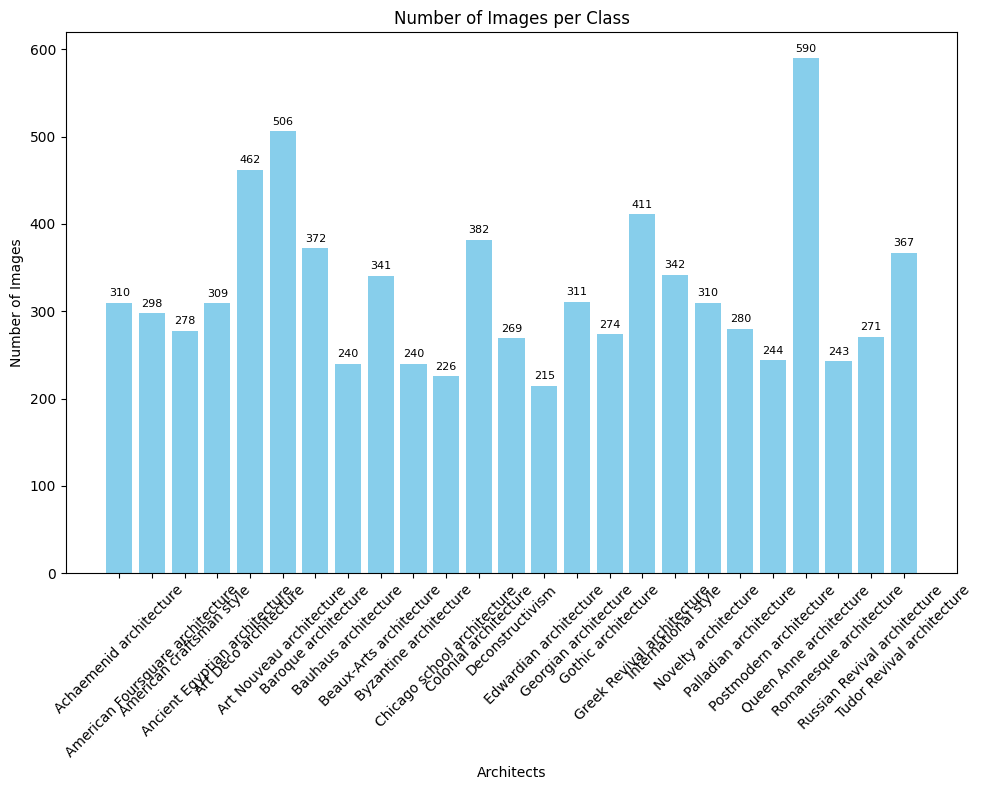

In [ ]:
plot_dataset_distribution(styles_train_ds, styles_class_names)

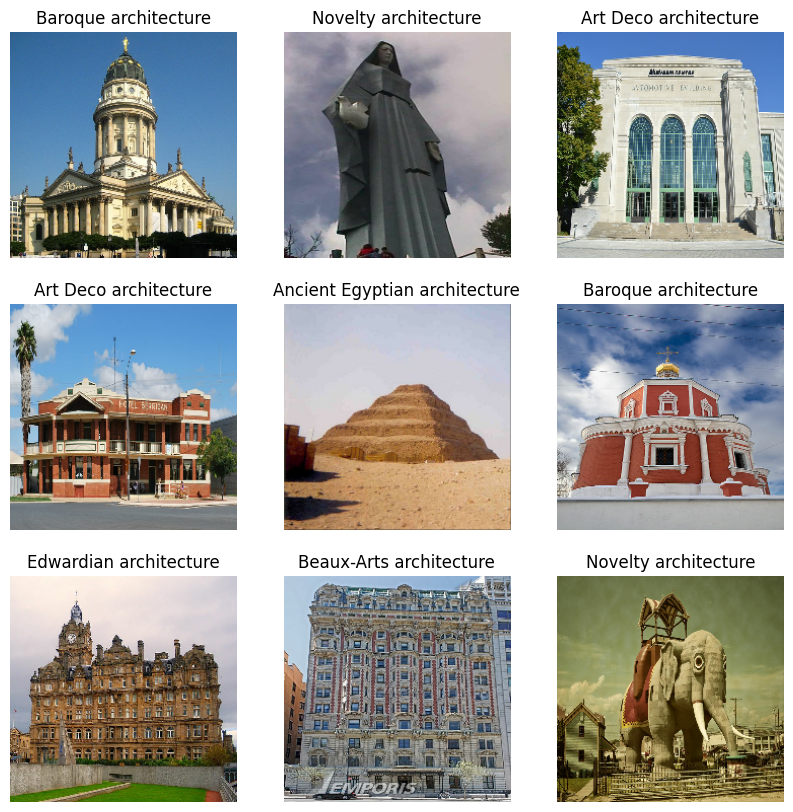

In [ ]:
plot_dataset(styles_train_ds, styles_class_names)

## Architects Dataset from Hugging Face

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects-top

Git LFS initialized.
Cloning into 'architects-top'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (1102/1102), done.
remote: Compressing objects: 100% (1102/1102), done.
remote: Total 1106 (delta 0), reused 0 (delta 0), pack-reused 4
Receiving objects: 100% (1106/1106), 155.44 KiB | 7.40 MiB/s, done.
Filtering content: 100% (1140/1140), 452.94 MiB | 24.51 MiB/s, done.


In [ ]:
from pathlib import Path
import shutil
import imghdr

data_dir = "/content/architects-top/data"
image_extensions = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
seed = 275

load_dataset(data_dir, img_height, img_width, batch_size, seed)

Found 1076 files belonging to 3 classes.
Using 861 files for training.
Found 1076 files belonging to 3 classes.
Using 215 files for validation.


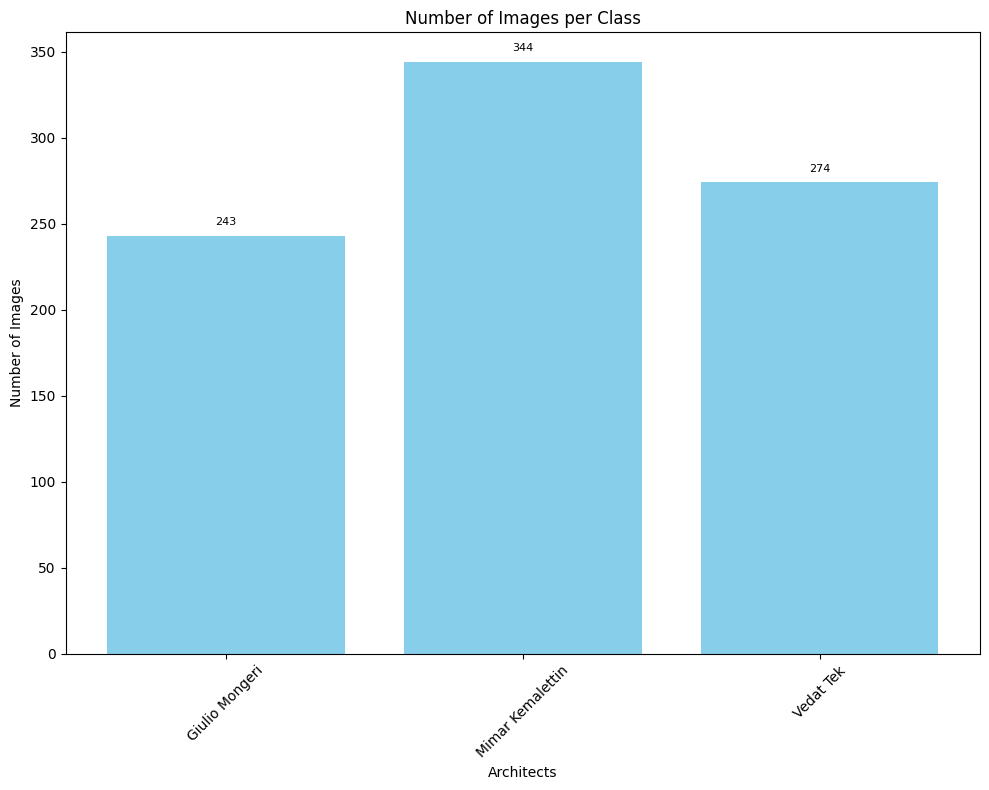

In [ ]:
plot_dataset_distribution(train_ds, class_names)

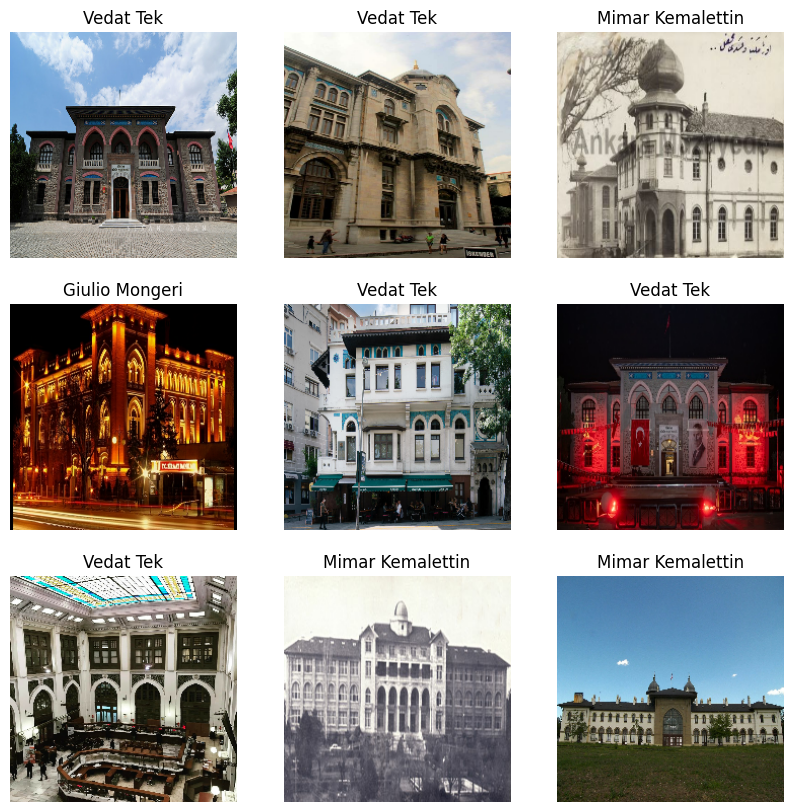

In [ ]:
# Keep the number of classes for for the softmax activation
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

plot_dataset(train_ds, class_names)

# Data Preprocessing (Normalization & Augmentation)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Standardizes pixel values to the [0, 1] range
# Having features on a similar scale can help the gradient descent converge more quickly towards the minima
rescale = tf.keras.Sequential([
  Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
])

def prepare(ds, shuffle=False, augment=False):
  # Rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Configure the dataset for performance
  # https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

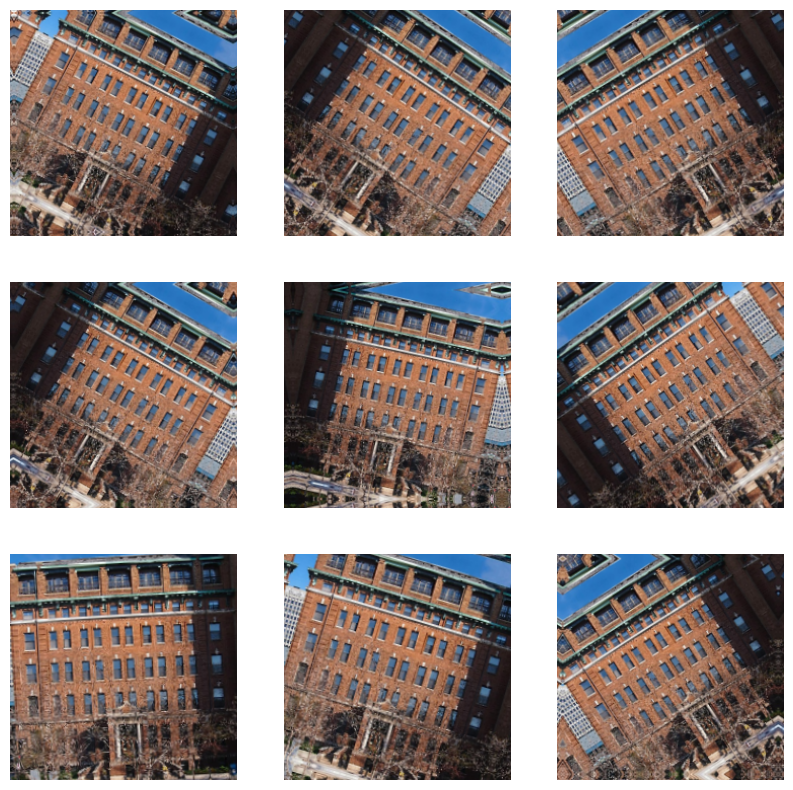

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in styles_train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
styles_train_ds = prepare(styles_train_ds)
styles_val_ds = prepare(styles_val_ds)

In [ ]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

# Deep Learning Model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, val_ds):
  # Get true labels from validation dataset
  true_labels = []
  for _, labels in val_ds:
      true_labels.extend(labels.numpy())

  # Make predictions using the validation dataset
  predicted_probs = model.predict(val_ds)
  predicted_labels = np.argmax(predicted_probs, axis=1)

  # Generating the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Displaying the confusion matrix using seaborn heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

def plot_performance(history):
  # Accessing training/validation accuracies and losses
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, len(train_acc) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 100
batch_size = 32

model_file_path = "saved_models/weights-improvement-{epoch:02d}-{val_loss:.2f}.keras"

checkpoint = ModelCheckpoint(
    model_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0, # Minimum change in the monitored quantity
    patience=10,
    mode='min')

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    # factor=np.sqrt(0.1),
    patience=5,
    min_lr=1e-6)

callbacks_list = [checkpoint, early_stop, lr_reducer]

## Training a Model from Scratch

In [ ]:
model = Sequential()
# Add the preprocessing layers you created earlier.
model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 21s 420ms/step - loss: 3.3794 - accuracy: 0.3403 - val_loss: 1.0730 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 14s 435ms/step - loss: 1.0845 - accuracy: 0.3926 - val_loss: 1.0872 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 15s 418ms/step - loss: 1.0774 - accuracy: 0.3995 - val_loss: 1.0584 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 536ms/step - loss: 1.0529 - accuracy: 0.4297 - val_loss: 1.0500 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 16s 492ms/step - loss: 1.0601 - accuracy: 0.4472 - val_loss: 1.0519 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 14s 421ms/step - loss: 1.0572 - accuracy: 0.4413 - val_loss: 1.0258 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 17s 5

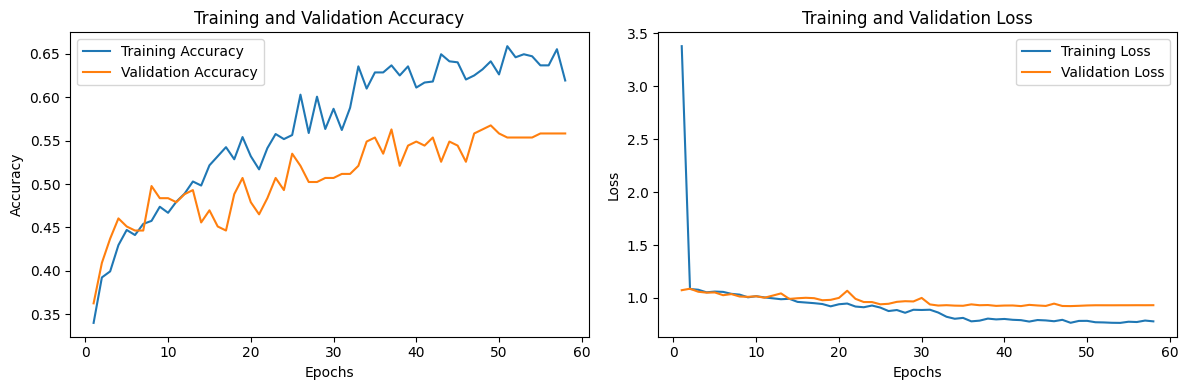

In [ ]:
plot_performance(history)

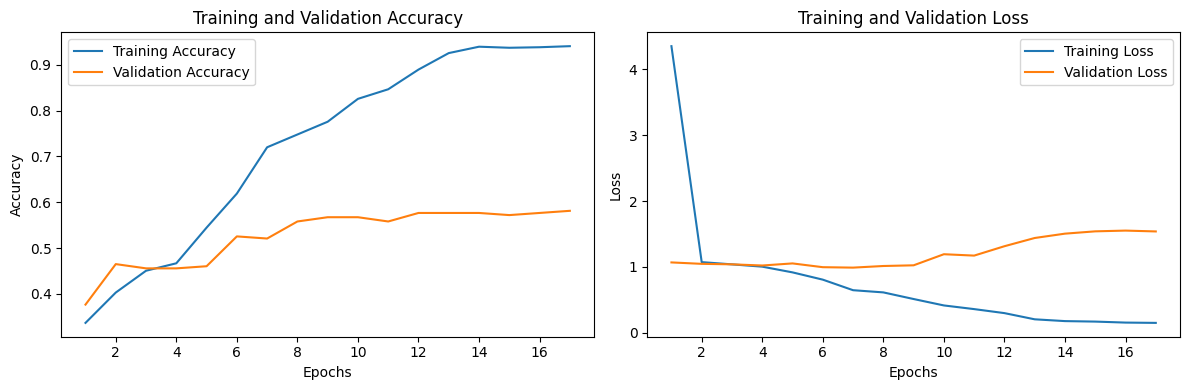

In [ ]:
plot_performance(history) # without any data augmentation (overfitting in 20 epoch)

## Transfer Learning

In [ ]:
from tensorflow.keras.applications import VGG16

 Transfer learning is a very good approach if we have less data for our problem statement.

### Fine Tuning VGG

### Fine Tuning VGG with Architectural Styles Dataset

In [ ]:
vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the pretrained weights
vgg_model.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.4)(x)
prediction = Dense(styles_num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    styles_train_ds,
    epochs=30, ####################3 Change
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
253/253 [==============================] - 71s 243ms/step - loss: 2.0572 - accuracy: 0.3980 - val_loss: 1.6907 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 2/30
253/253 [==============================] - 49s 188ms/step - loss: 1.1459 - accuracy: 0.6411 - val_loss: 1.4880 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 3/30
253/253 [==============================] - 47s 183ms/step - loss: 0.6925 - accuracy: 0.7857 - val_loss: 1.7309 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 4/30
253/253 [==============================] - 47s 182ms/step - loss: 0.3877 - accuracy: 0.8830 - val_loss: 1.7208 - val_accuracy: 0.5574 - lr: 0.0010
Epoch 5/30
253/253 [==============================] - 58s 225ms/step - loss: 0.2269 - accuracy: 0.9339 - val_loss: 1.9220 - val_accuracy: 0.5598 - lr: 0.0010
Epoch 6/30
253/253 [==============================] - 49s 189ms/step - loss: 0.1376 - accuracy: 0.9621 - val_loss: 1.9303 - val_accuracy: 0.5692 

In [ ]:
vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the pretrained weights
vgg_model.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.4)(x)
prediction = Dense(styles_num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    styles_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Epoch 1/100
253/253 [==============================] - 49s 184ms/step - loss: 10.1099 - accuracy: 0.2871 - val_loss: 6.0547 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 2/100
253/253 [==============================] - 46s 180ms/step - loss: 4.8385 - accuracy: 0.5255 - val_loss: 4.6239 - val_accuracy: 0.4515 - lr: 0.0010
Epoch 3/100
253/253 [==============================] - 47s 182ms/step - loss: 3.3127 - accuracy: 0.6654 - val_loss: 3.9289 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 4/100
253/253 [==============================] - 46s 178ms/step - loss: 2.6362 - accuracy: 0.7427 - val_loss: 3.9697 - val_accuracy: 0.4881 - lr: 0.0010
Epoch 5/100
253/253 [==============================] - 48s 185ms/step - loss: 2.3777 - accuracy: 0.7717 - val_loss: 3.7329 - val_accuracy: 0.5015 - lr: 0.0010
Epoch 6/100
253/253 [==============================] - 47s 182ms/step - loss: 2.2057 - accuracy: 0.7997 - val_loss: 3.8363 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 7/100
253/253 [========================

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
prediction = Dense(styles_num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    styles_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Epoch 1/100
253/253 [==============================] - 51s 195ms/step - loss: 10.7012 - accuracy: 0.1424 - val_loss: 6.7010 - val_accuracy: 0.2290 - lr: 0.0010
Epoch 2/100
253/253 [==============================] - 45s 175ms/step - loss: 6.0641 - accuracy: 0.2089 - val_loss: 4.8989 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 3/100
253/253 [==============================] - 47s 181ms/step - loss: 4.7050 - accuracy: 0.2865 - val_loss: 4.0005 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 4/100
253/253 [==============================] - 46s 177ms/step - loss: 3.9180 - accuracy: 0.3417 - val_loss: 3.4367 - val_accuracy: 0.3843 - lr: 0.0010
Epoch 5/100
253/253 [==============================] - 46s 180ms/step - loss: 3.4107 - accuracy: 0.3852 - val_loss: 3.1364 - val_accuracy: 0.4120 - lr: 0.0010
Epoch 6/100
253/253 [==============================] - 46s 180ms/step - loss: 3.0632 - accuracy: 0.4237 - val_loss: 3.0910 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 7/100
253/253 [========================

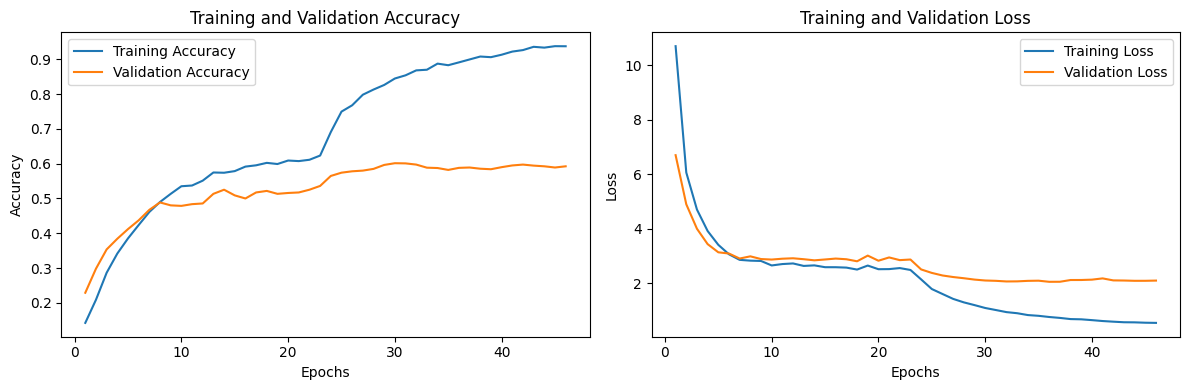

In [ ]:
plot_performance(transfer_history)

In [ ]:
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(styles_num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model.fit(
    styles_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Model: "model_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 vgg16 (Functional)          (None, 7, 7, 512)         1471468   N          
                                                       8                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout_7 (Dropout)         (None, 512)               0         Y          
                                                                            
 dense_16 (Dense)            (None, 25)                1282

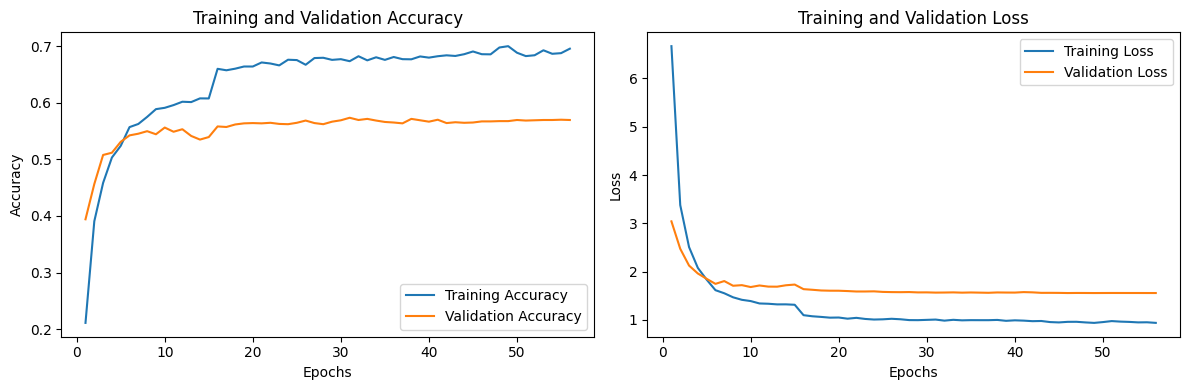

In [ ]:
plot_performance(history)

In [ ]:
# lets apply data augmentation

from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = vgg_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(styles_num_classes, activation='softmax')(x)

transfer_model = Model(inputs, outputs)

# Add the data augmentation layer as the first layer of your model
model = tf.keras.Sequential([
    data_augmentation,
    transfer_model
])

model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model.fit(
    styles_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Epoch 1/100
253/253 [==============================] - 69s 209ms/step - loss: 3.0451 - accuracy: 0.1332 - val_loss: 2.8096 - val_accuracy: 0.2463 - lr: 0.0010
Epoch 2/100
253/253 [==============================] - 49s 187ms/step - loss: 2.6993 - accuracy: 0.2537 - val_loss: 2.5536 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 3/100
253/253 [==============================] - 47s 183ms/step - loss: 2.5108 - accuracy: 0.3043 - val_loss: 2.3932 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 4/100
253/253 [==============================] - 47s 182ms/step - loss: 2.3722 - accuracy: 0.3365 - val_loss: 2.2762 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 5/100
253/253 [==============================] - 45s 177ms/step - loss: 2.2864 - accuracy: 0.3552 - val_loss: 2.1937 - val_accuracy: 0.3932 - lr: 0.0010
Epoch 6/100
253/253 [==============================] - 47s 180ms/step - loss: 2.2090 - accuracy: 0.3692 - val_loss: 2.1295 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 7/100
253/253 [=========================

KeyboardInterrupt: 

In [ ]:
# NOT TESTED YET (the above model get stucked, I guess we need to increase the model complexity, so lets add additional dense layer with dropout)

base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(styles_num_classes, activation='softmax')(x)
transfer_model = keras.Model(inputs, outputs)


transfer_model = Model(inputs, outputs)

# Add the data augmentation layer as the first layer of your model
model = tf.keras.Sequential([
    data_augmentation,
    transfer_model
])


model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

# model.summary(show_trainable=True)

history = model.fit(
    styles_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Epoch 1/100
253/253 [==============================] - 51s 188ms/step - loss: 2.8662 - accuracy: 0.1741 - val_loss: 2.4028 - val_accuracy: 0.3412 - lr: 0.0010
Epoch 2/100
253/253 [==============================] - 48s 183ms/step - loss: 2.3565 - accuracy: 0.2953 - val_loss: 2.1249 - val_accuracy: 0.3754 - lr: 0.0010
Epoch 3/100
253/253 [==============================] - 46s 179ms/step - loss: 2.1727 - accuracy: 0.3463 - val_loss: 1.9447 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 4/100
253/253 [==============================] - 47s 182ms/step - loss: 2.0883 - accuracy: 0.3602 - val_loss: 1.9289 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 5/100
253/253 [==============================] - 46s 180ms/step - loss: 2.0145 - accuracy: 0.3871 - val_loss: 1.8600 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 6/100
253/253 [==============================] - 47s 182ms/step - loss: 1.9611 - accuracy: 0.4032 - val_loss: 1.8184 - val_accuracy: 0.4515 - lr: 0.0010
Epoch 7/100
253/253 [=========================

KeyboardInterrupt: 

In [ ]:
plot_performance(history)

In [ ]:
vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the pretrained weights
vgg_model.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(styles_num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    styles_train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Epoch 1/100
253/253 [==============================] - 77s 245ms/step - loss: 4.2569 - accuracy: 0.1122 - val_loss: 3.0355 - val_accuracy: 0.2290 - lr: 0.0010
Epoch 2/100
253/253 [==============================] - 48s 187ms/step - loss: 3.0531 - accuracy: 0.1390 - val_loss: 2.7168 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 3/100
253/253 [==============================] - 46s 178ms/step - loss: 2.8986 - accuracy: 0.1599 - val_loss: 2.6237 - val_accuracy: 0.2829 - lr: 0.0010
Epoch 4/100
253/253 [==============================] - 47s 182ms/step - loss: 2.8417 - accuracy: 0.1657 - val_loss: 2.5189 - val_accuracy: 0.2745 - lr: 0.0010
Epoch 5/100
253/253 [==============================] - 45s 176ms/step - loss: 2.8104 - accuracy: 0.1756 - val_loss: 2.4860 - val_accuracy: 0.2809 - lr: 0.0010
Epoch 6/100
253/253 [==============================] - 47s 182ms/step - loss: 2.7684 - accuracy: 0.1807 - val_loss: 2.4796 - val_accuracy: 0.2834 - lr: 0.0010
Epoch 7/100
253/253 [=========================

KeyboardInterrupt: 

### Exp: Default VGG

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

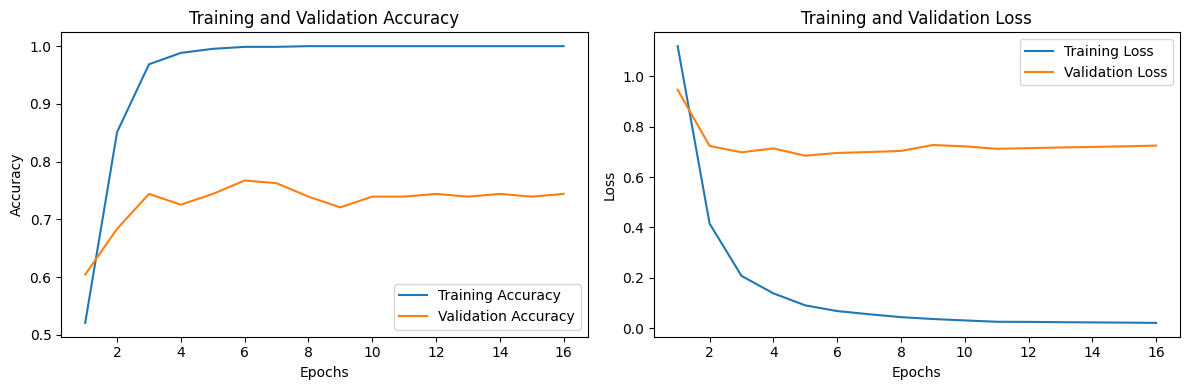

In [ ]:
plot_performance(transfer_history)

### Exp: Add Second Dense Layer ***

### Without Data Augmentation

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/100
27/27 [==============================] - 35s 883ms/step - loss: 6.4184 - accuracy: 0.3635 - val_loss: 4.0936 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 16s 502ms/step - loss: 3.6756 - accuracy: 0.4437 - val_loss: 3.0075 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 18s 563ms/step - loss: 2.6810 - accuracy: 0.5575 - val_loss: 2.3548 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 514ms/step - loss: 2.1392 - accuracy: 0.6585 - val_loss: 2.0014 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 17s 514ms/step - loss: 1.8320 - accuracy: 0.6736 - val_loss: 1.7775 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 18s 544ms/step - loss: 1.5974 - accuracy: 0.7073 - val_loss: 1.6336 - val_accuracy: 0.6698 - lr: 

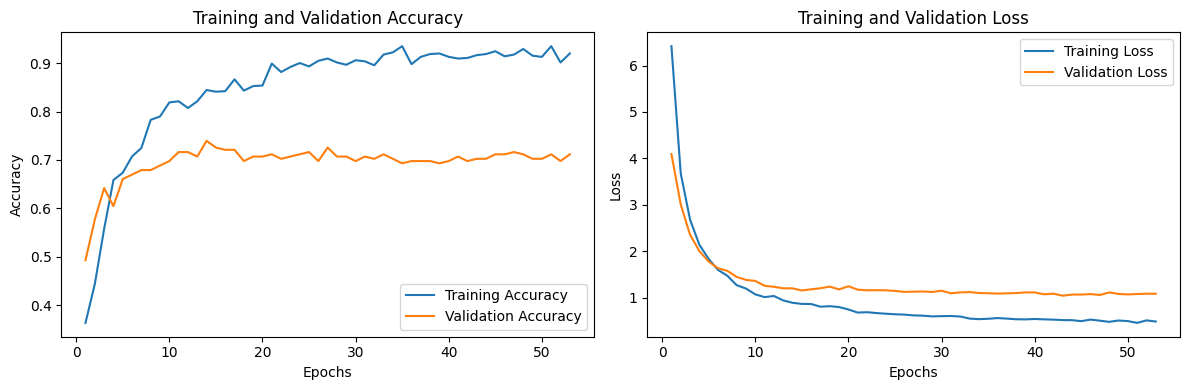

In [ ]:
plot_performance(transfer_history)

7/7 [==============================] - 4s 133ms/step


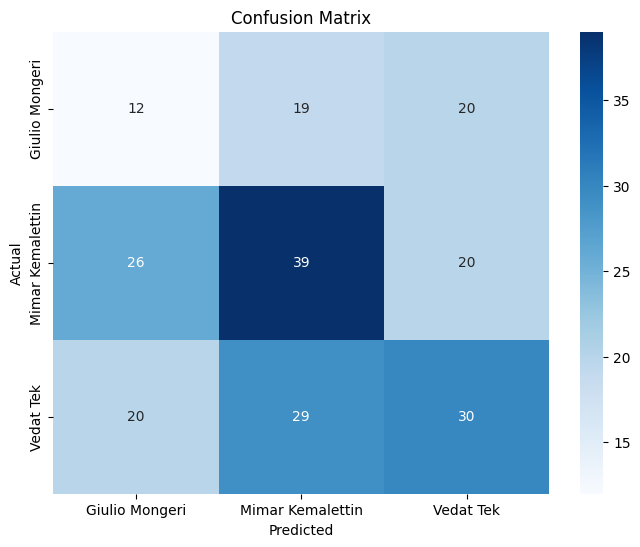

In [ ]:
plot_confusion_matrix(transfer_model, val_ds)

loss: 7.4140 - accuracy: 0.7965 - val_loss: 6.2185 - val_accuracy: 0.7628 - lr: 0.0010

### With Data Augmentation

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

# Add the data augmentation layer as the first layer of your model
model_with_augmentation = tf.keras.Sequential([
    data_augmentation,
    transfer_model
])

model_with_augmentation.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model_with_augmentation.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 20s 559ms/step - loss: 6.1240 - accuracy: 0.3891 - val_loss: 3.9209 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 17s 515ms/step - loss: 3.3570 - accuracy: 0.4518 - val_loss: 2.7839 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 16s 469ms/step - loss: 2.5699 - accuracy: 0.4495 - val_loss: 2.2308 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 508ms/step - loss: 2.0808 - accuracy: 0.4959 - val_loss: 1.8748 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 15s 474ms/step - loss: 1.8444 - accuracy: 0.5250 - val_loss: 1.7526 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 18s 512ms/step - loss: 1.7449 - accuracy: 0.4797 - val_loss: 1.8116 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 16s 4

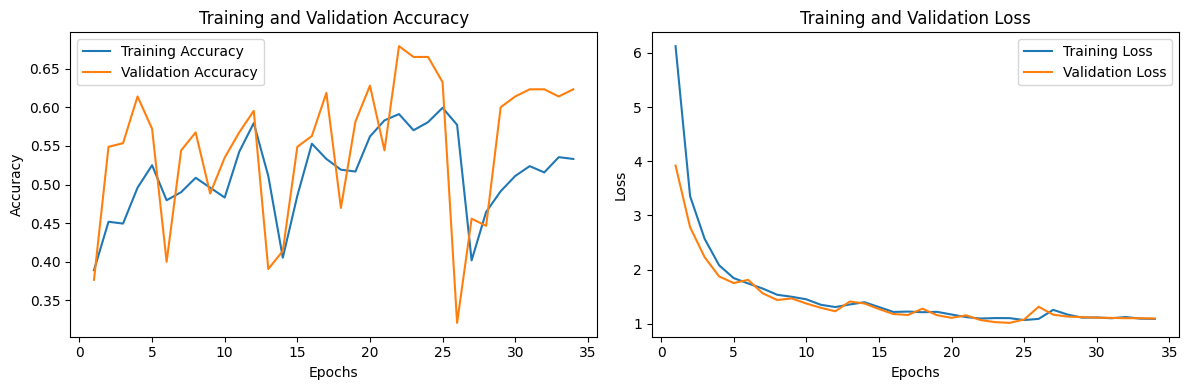

In [ ]:
plot_performance(history)

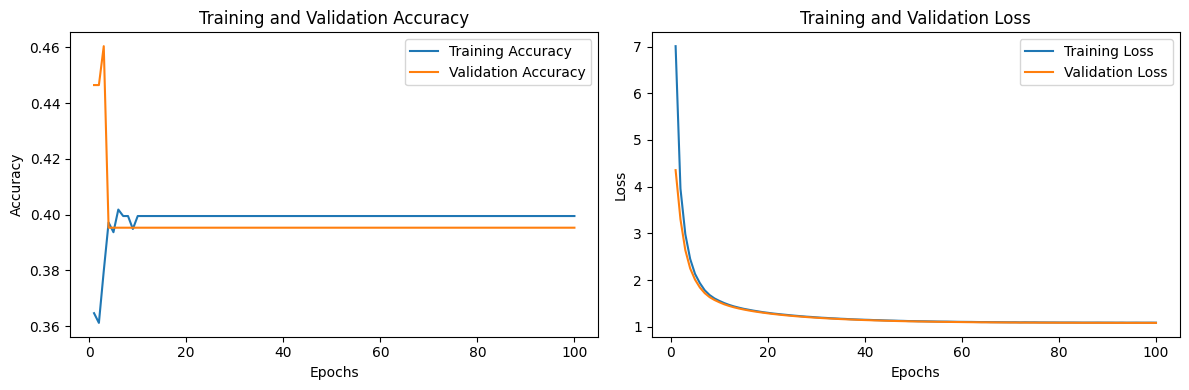

In [ ]:
plot_performance(history) # .4 dropout

### Exp: New Type of NN **

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 vgg16 (Functional)          (None, 7, 7, 512)         1471468   N          
                                                       8                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout_2 (Dropout)         (None, 512)               0         Y          
                                                                            
 dense_3 (Dense)             (None, 3)                 1539

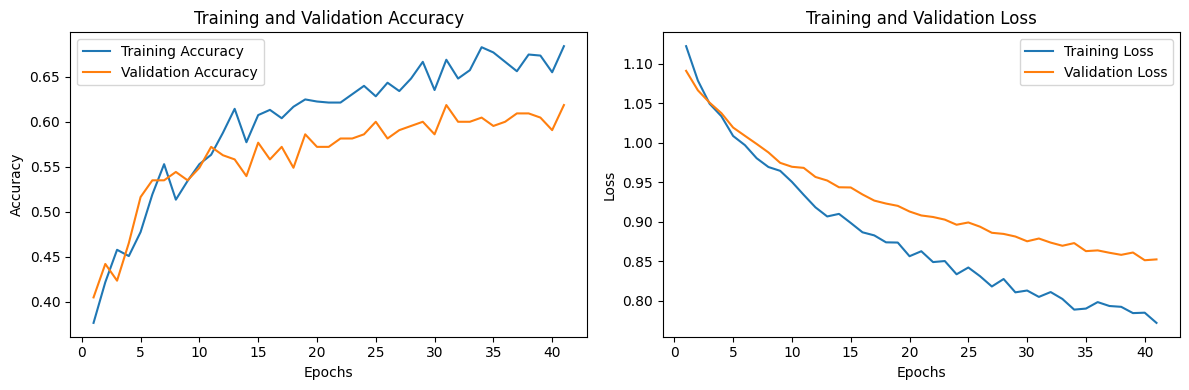

In [ ]:
plot_performance(history)

## Fine-tuning

# Hyperparameter Tuning - Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define a function that builds the model with the specified hyperparameters
def create_model(dropout):
  # TODO: Define the final model here
  model = Sequential()
  model.add(Flatten(input_shape=(7, 7, 512))) # change the input shapem
  model.add(Dropout(dropout))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])
  return model

# Creating a KerasClassifier using the build function
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=1)

# Define the grid search parameters
param_grid = {
    'batch_size':[8,16,32, 64],
    # 'learning_rate': [0.01, 0.1],
    # 'epochs':[50,70],
    # 'momentum': [0.9, 0.99],
    # 'weight_decay': [0.0001, 0.0005],
    'dropout': [0.2,0.3,0.4]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)
grid_result = grid.fit(train_ds)

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Predict on new data

In [ ]:
img_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Giulio Mongeri with a 57.61 percent confidence.


# Save the Model

In [ ]:
from tensorflow.keras.models import load_model

model_dir = os.path.join('models','vgg_arch_classifier.h5')

# model.save(model_dir)
transfer_model.save(model_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model = load_model(os.path.join('models','arch_classifier.h5'))

# K-means Clustering

In [ ]:
def plot_clusters(features, centroids, class_names):
  # Plot the 2D representation with centroids
  plt.figure(figsize=(8, 6))
  for i, class_name in enumerate(class_names):
      # Create a boolean array where each element is True if the corresponding label is equal to i, and False otherwise.
      cluster_points = features[labels == i]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

  # Plot centroids
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='black', label='Centroids')

  plt.title('Visualized on TSNE 2D')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
final_model.layers[:-1]

In [ ]:
def extract_features(model, data):
  feature_extractor = Sequential(model.layers[:-1])
  return feature_extractor.predict(data)

final_model = transfer_model

train_features = extract_features(final_model, train_ds)
val_features = extract_features(final_model, val_ds)
features = np.concatenate((train_features, val_features))

train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
labels = np.concatenate([train_labels, val_labels], axis=0)

7/7 [==============================] - 5s 130ms/step


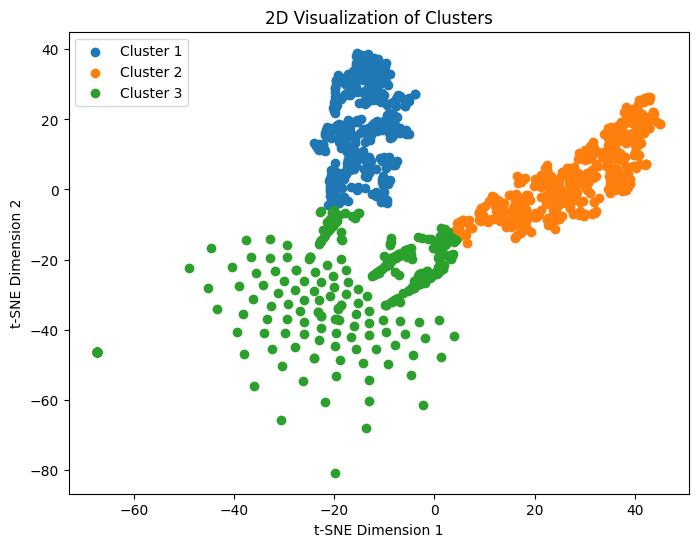

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2) # 2 dimension
features_tsne = tsne.fit_transform(features)

num_clusters = num_classes
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit_predict(features_tsne)

# Get cluster labels for each image
cluster_labels = kmeans.labels_

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(features_tsne[cluster_labels == i, 0], features_tsne[cluster_labels == i, 1], label=f'Cluster {i+1}')
plt.title('2D Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()